In [418]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path

from datetime import datetime

from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess
from shapely.geometry import Polygon, Point

In [419]:
def locate_ground_surface_lay(row=150):
    cross_section = ibound[:,:,0]
    lay = np.where(cross_section[:,row]==1)[0][0]
    return lay

def meter_to_col(col_meter):
    return int(np.round(col_meter/delc,0))

def meter_to_row(row_meter):
    return int(np.round(row_meter/delc,0))

def meter_to_lay(lay_meter):
    return int(np.round((top_elev-lay_meter)/layer_thickness,0))


def col_to_meter(col):
    return col*delc

def row_to_meter(row):
    return row*delc

def lay_to_meter(row):
    return 190.0-row*layer_thickness

In [420]:

def change_array_within_polygon(array, row_coords, col_coords, value):

    # Create a polygon object from the row and column coordinates
    polygon = Polygon(zip(col_coords, row_coords))

    # Create a boolean mask indicating which points fall within the polygon
    mask = np.zeros_like(array, dtype=bool)
    for row in range(array.shape[0]):
        for col in range(array.shape[1]):
            point = Point(col, row)
            if polygon.contains(point) or polygon.intersects(point):
                mask[row, col] = True

    # Set the values of the array that fall within the polygon to the new value
    array[mask] = value

    return array


# Workspace

In [511]:
# Define model workspace

myt = datetime.now().strftime('%m%d%H%M%S')
name = 'wasaga'
temp_dir = mkdtemp(prefix='_T{}_{}_'.format(myt,name))
os.makedirs(Path(temp_dir) / '_output')

#model_ws = "./modflow_model_2"
model_ws = temp_dir

def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

open_file(model_ws)

# Model

In [512]:
# Create a MODFLOW model instance
model = flopy.modflow.Modflow(modelname="example_model",version='mf2005',
                              exe_name='mf2005', 
                              model_ws=model_ws)

In [513]:
# Create a MODFLOW model instance
model = flopy.seawat.Seawat(modelname="example_model",
                            exe_name='swtv4', 
                              model_ws=model_ws)


# DIS

In [514]:
# Define model dimensions
nlay = int(60*1)
nrow = int(220*1)
ncol = int(220*1)
delr = 2200/nrow  # Cell width along rows (extend 2200 / 220)
delc = 2200/ncol  # Cell width along columns (extend 2200 / 220)

# Define top elevation
layer_thickness = 30.0 / nlay

top_elev = 190.0
botm_elev = [top_elev - (i * layer_thickness) for i in range(1, nlay + 1)]
# Define layer thickness (uniform thickness)


perlen = 365
nper = int(10)

steady = np.append(np.array([True]),np.repeat(False,nper-1))
#steady=[False,False,True]
#steady = True

# Create DIS package
dis = flopy.modflow.ModflowDis(model, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=delr, delc=delc,top=top_elev, 
                               botm=botm_elev,
                               nper = nper, perlen = perlen,
                               nstp = 1, steady = steady)



# Ibound

In [515]:
from scipy.interpolate import make_interp_spline

x = np.array([0, 100, 340, 600, 750, 850, 1100, 1350, 1450, 1530, 1650, 1750, 1850, 2050, 2200])
y_topo = np.array([190,190,187,184,184,184,183,182,179,175.5,175,173.8,173.5,172,171])#topo
y_clay = np.array([185,184,180,175,174,174,173,170,169,168.5,167.5,166.8,166.5,165,164]) #clay



# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_topo)
x_smooth_topo = np.linspace(x.min(), x.max(), 30)
y_smooth_topo = spl(x_smooth_topo)

col_coords = (x_smooth_topo/delr).round(0)
col_coords_topo = list(col_coords) +[nrow,0]

row_coords = ((top_elev - y_smooth_topo)/layer_thickness).round(0)
row_coords_topo  =  list(row_coords) +[0,0]



# Interpolate the data using smoothing splines
spl = make_interp_spline(x, y_clay)
x_smooth = np.linspace(x.min(), x.max(), 30)
y_smooth = spl(x_smooth)

col_coords = (x_smooth/delr).round(0)
col_coords_clay = list(col_coords) +[nrow,0]
row_coords = ((top_elev - y_smooth)/layer_thickness).round(0)
row_coords_clay  =  list(row_coords) +[nlay,nlay]


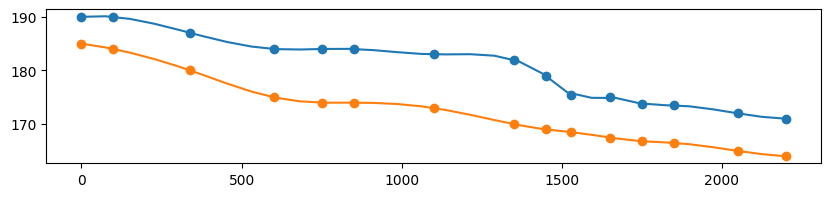

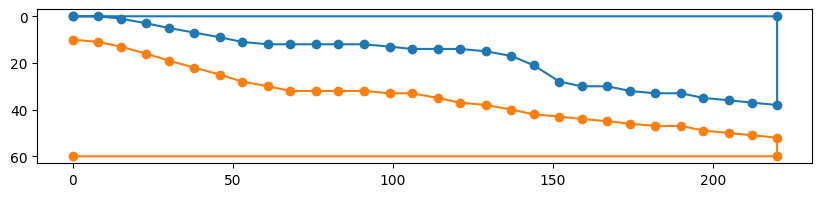

In [516]:

plt.scatter(x, y_topo)
plt.plot(x_smooth_topo, y_smooth_topo)

# Plot the original data and the smooth curve
plt.scatter(x, y_clay)
plt.plot(x_smooth, y_smooth)


plt.gcf().set_size_inches(10,2)
# Show the plot
plt.show()


plt.plot(col_coords_topo,row_coords_topo)
plt.scatter(col_coords_topo,row_coords_topo)

plt.plot(col_coords_clay,row_coords_clay)
plt.scatter(col_coords_clay,row_coords_clay)

plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10,2)

# Ibound & Strt

185.5
186.0
186.5
185.0
185.5
186.0
186.5


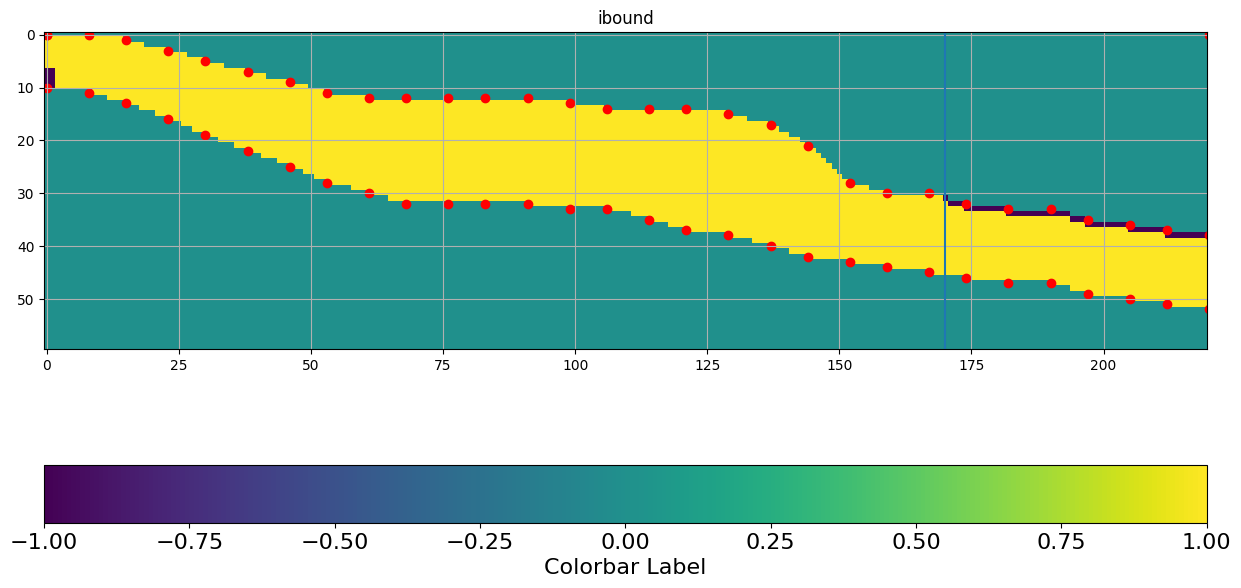

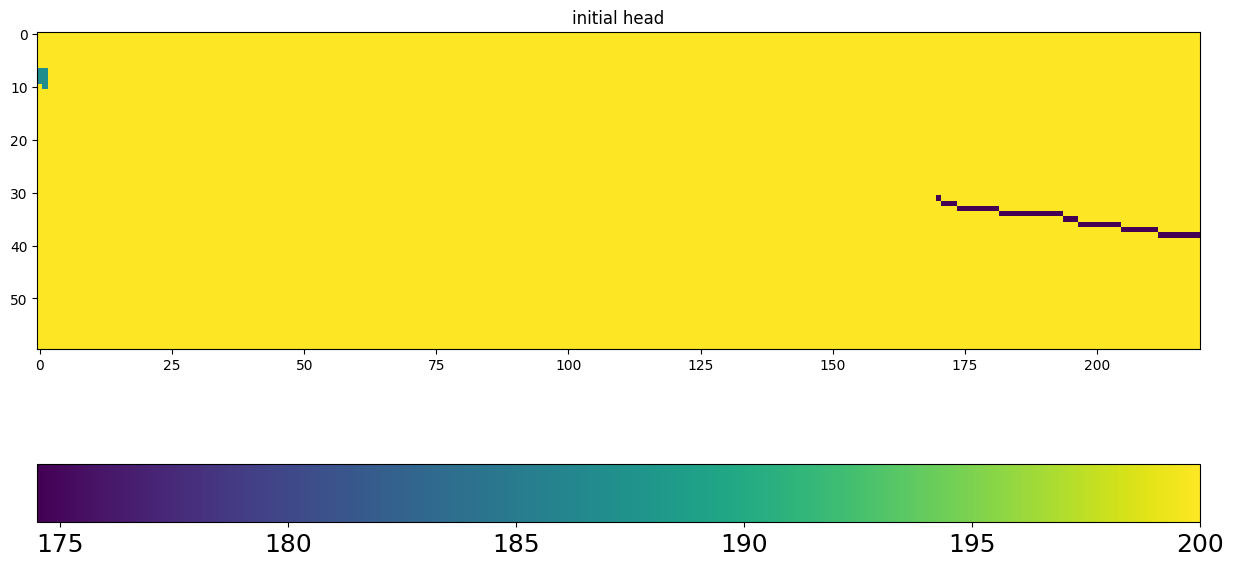

In [517]:

# Define ibound and initial conditionsa
ibound = np.ones((nlay, nrow, ncol), dtype=int)
initial_head = np.full((nlay, nrow, ncol), 200.0, dtype=float)

# Set constant head boundary conditions for the first and last rows
array = change_array_within_polygon(ibound, row_coords_topo, col_coords_topo, 0)
plt.scatter(col_coords_topo,row_coords_topo,c='r')


array = change_array_within_polygon(ibound, row_coords_clay, col_coords_clay, 0)
plt.scatter(col_coords,row_coords,c='r')


for c in range(0,2):
    i = np.where(ibound[:,c,-1]==1)[0][-1]
    head = top_elev-i*layer_thickness
    #print('head {}'.format(head))
    
    while head<187:
        ibound[i,c,:] = -1
        #print(i,c)
        #initial_head[i,c,:] = head+0.5
        print(head)
        initial_head[i,c,:] = 187
        head+=layer_thickness
        i-=1


lay = np.where(ibound[:,int(1700/delr),-1])[0][0]
elv = lay_to_meter(lay)
head = elv

for c in range(int(1700/delr),int(2200/delr)):
    lay = np.where(ibound[:,c,-1]==1)[0][0]
    #print(lay,lay_to_meter(lay))
    ibound[lay,c,:] = -1
    initial_head[lay,c,:] = elv



#TEMP
# lay0 = np.where(ibound[:,-1,-1]==1)[0][0]
# lay1 = np.where(ibound[:,-1,-1]==1)[0][-1]
# ibound[lay0:lay1+1,-1,:] = -1
# head = 190-lay0*layer_thickness
# initial_head[lay0:lay1+1,-1,:] = head
# print(head, head)



# Your existing code
im = plt.imshow(ibound[:,:,2], origin='upper', aspect=1)
plt.axvline(x=meter_to_col(1700))# shoreline
plt.gcf().set_size_inches(15,10)

# Set the y-axis tick positions and labels
#plt.yticks([0, 10,20, 30,40, 50,60], ['190m (0L)','185m (10L)', '180m (20L)','175m (30L)', '170m (40L)', '165m (50L)','160m (60L)'])

# Add a horizontal colorbar
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Colorbar Label', fontsize=16)

# Display the plot
plt.title('ibound')
plt.grid()
plt.show()


fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(initial_head[:, :, 0], origin='upper')

# Add a horizontal colorbar
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=18)
plt.title('initial head')
plt.show()



# BAS LPF  PCG

In [518]:

# Create BAS package
bas = flopy.modflow.ModflowBas(model, ibound=ibound, strt=initial_head)

# Define hydraulic properties
horizontal_k = 2.3  # Horizontal hydraulic conductivity (m/day)
vertical_ka = 0.1   # Vertical hydraulic conductivity (m/day)
porosity = 0.25     # Porosity

# Create LPF package (Layer Property Flow package)
lpf = flopy.modflow.ModflowLpf(model, hk=horizontal_k, 
                               vka=vertical_ka, laytyp=1, 
                               ipakcb=None,ss=0.0002,sy=0.33,
                               laywet=1,iwetit=1,wetfct=0.1,ihdwet=1)

# #ss=0.0002,sy=0.33
# upw = flopy.modflow.ModflowUpw(model, laytyp=1, hk=horizontal_k)

pcg = flopy.modflow.ModflowPcg(model, hclose=1e-3,npcond=1,relax=0.99,rclose=1e-3,mutpcg=0,nbpol=1,iprpcg=1)

#pcgn = flopy.modflow.ModflowPcgn(model)
# OC - Output Control Option

oc = flopy.modflow.ModflowOc(

    model,
    stress_period_data= None,
    compact=True,
)


# DRN

In [519]:
locate_ground_surface_lay(meter_to_row(160))
#drn_cell = [(0, 150, 28), -10, 100]

beach_drns = np.arange(1520,1600+1,delr).astype(int)
river_drns = np.arange(595,605+1,delr).astype(int)

drn_list = []

drn_ys= list(beach_drns)+list(river_drns)

for y in drn_ys:
   row = meter_to_row(y)
   lay = locate_ground_surface_lay(row=row)
   elv = lay_to_meter(lay)
   #print(lay)
   for col in range(ncol):

      drn_list.append([lay, row, col, elv, 100])
      #drn_list.append([12*2, meter_to_row(600), col, 184.0-0.5, 100])
      
drn_cell = {0:drn_list} 

#drn_cell={0:[[31, 160, 0, 174.5-0.5, 0],[12, 60, 0, 184.0-0.5, 0]]}
drn = flopy.modflow.ModflowDrn(model=model, stress_period_data=drn_cell,)

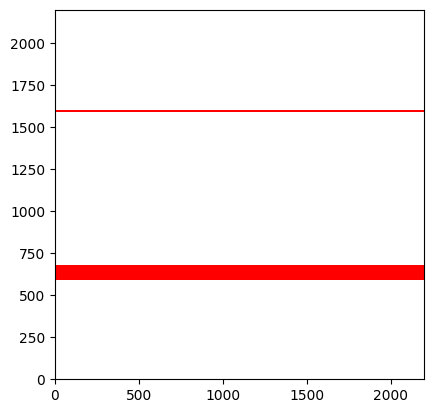

In [520]:
lays_with_drn = np.unique([i[0] for i in drn.stress_period_data.data[0]])
for lay in lays_with_drn:
    pmv = flopy.plot.PlotMapView(model=model, layer=lay)
    pmv.plot_bc('DRN',color='r')


# ICBOUND

In [521]:
icbund = np.full((nlay, nrow, ncol),0, dtype=float)
icbund = ibound.copy()

btn = flopy.mt3d.Mt3dBtn(
    model,
    nprs=5,
    timprs=np.cumsum([200]*7),
    prsity=0.25,
    sconc= 1, # starting concentration
    ifmtcn=0, chkmas=False, nprobs=10, nprmas=10,
    dt0=5,  # The user-specified initial 
    ttsmult=1.5,
    mxstrn = 50000,
    icbund = icbund
)


In [522]:
adv = flopy.mt3d.Mt3dAdv(model, mixelm=0,percel=0.4,mxpart=200000,nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(model, al=0.2, trpt=0.1, 
                        trpv=0.1, 
                        dmcoef=3.7E-10 )
gcg = flopy.mt3d.Mt3dGcg(model, iter1=50, mxiter=1, isolve=2, cclose= 1e-5)

# RCH

In [523]:
crch_array =  np.full(( nrow, ncol), 0, dtype=float)
crch_array[int(nrow/2),int(ncol/2)] =5000
ssm = flopy.mt3d.Mt3dSsm(model, crch=crch_array)

In [524]:
rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)

rch_array[int(nrow/2),int(ncol/2)] = 0.51/delr/delc
rch = flopy.modflow.ModflowRch(model = model, rech = rch_array)

# WEL and SSM

In [525]:
# ## 60*220*220

# wt = np.array([ 6,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12,
#        12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
#        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 13,
#        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14,
#        14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
#        16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18,
#        18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21,
#        21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25,
#        25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29,
#        29, 29, 29, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
#        31, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34,
#        34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36,
#        36, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38])

In [526]:

# ## 120x440x440
# wt= np.array([12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14,
#        14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16,
#        16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18,
#        18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20,
#        20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22,
#        22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
#        23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25,
#        26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28,
#        28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31,
#        32, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35,
#        35, 36, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38,
#        39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41,
#        41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 44,
#        44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46, 46, 47,
#        47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 48,
#        48, 48, 48, 48, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 49, 49,
#        49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51, 51, 51,
#        51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 53, 54, 55, 56, 57, 57, 57,
#        57, 58, 58, 58, 58, 59, 59, 59, 59, 60, 62, 64, 64, 64, 63, 63, 64,
#        64, 65, 66, 66, 66, 66, 67, 61, 61, 61, 61, 62, 62, 62, 62, 63, 63,
#        63, 63, 64, 64, 64, 64, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 66,
#        66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
#        67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69,
#        69, 69, 69, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 72, 72, 72,
#        72, 72, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75,
#        76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76])

In [527]:

# def add_to_dict(spd, kper, value):

#     if kper in spd:
#         spd[kper].append(value)
#     else:
#         spd[kper] = [value]

# ##----------------------------------------------------------#


# wel_data = [
#     #[layer, row, col, input_rate,start_kper,end_kper,conc]
#     [wt[meter_to_row(250)]+1,meter_to_row(250),meter_to_col(200),0.51,1,3,5000],
#     [wt[meter_to_row(750)]+1,meter_to_row(750),meter_to_col(200),0.51,1,3,5000],
#     [wt[meter_to_row(650)]+1,meter_to_row(650),meter_to_col(600),0.51,2,4,5000],
#     [wt[meter_to_row(990)]+1,meter_to_row(990),meter_to_col(990),0.51,2,4,5000],
#     [wt[meter_to_row(1000)]+1,meter_to_row(1000),meter_to_col(1000),0.51,30,40,5000]
#  ]


# spd_wel = {}
# for i in wel_data:
#     add_to_dict(spd_wel,i[4],[i[0],i[1],i[2],i[3]])
#     add_to_dict(spd_wel,i[5],[i[0],i[1],i[2],0.0])

# wel = flopy.modflow.ModflowWel(model, stress_period_data=spd_wel, ipakcb=53)

# #----------------------------------------------------

# spd_ssm = {}
# itype = flopy.mt3d.Mt3dSsm.itype_dict()
# for i in wel_data:
#     add_to_dict(spd_ssm,i[4],[i[0],i[1],i[2],i[6],itype['WEL']])
#     add_to_dict(spd_ssm,i[5],[i[0],i[1],i[2],0.0,itype['WEL']])


# wel = flopy.modflow.ModflowWel(model, stress_period_data=spd_wel, ipakcb=53)
# ssm = flopy.mt3d.Mt3dSsm(model, stress_period_data=spd_ssm)

# RCT

In [528]:
#rct = flopy.mt3d.Mt3dRct(model=model, isothm=3,sp1=0.0001,sp2=0.0001,igetsc=0,rhob= 1.65E+09)

# Write and Run

In [529]:

# Write MODFLOW input files
model.write_input()


Util2d rech_1: locat is None, but model does not support free format and how is internal... resetting how = external


In [530]:
open_file(model_ws)

In [531]:
# Run the MODFLOW model
model.run_model()

FloPy is using the following executable to run the model: C:\Users\swan47\AppData\Local\flopy\bin\swtv4.EXE

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: example_model.nam                                                                                                                                                                                       
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2023/10/20 15:19:06




 STRESS PERIOD NO.    1

  STRESS PERIOD    1 TIME STEP    1 FROM TIME =   0.0000     TO    365.00    

 Transport Step:    1   Step Size:   5.000     Total Elapsed Time:   5.0000    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   1184.      [K,I,J]   20  111  111
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   2.381      [K,I,J]   21  111  111
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.9460E-02  [K,I,J]   21  111  110
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3401E-04  [K,I,J]   21  111  110
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1324E-06  [K,I,J]   21  111  110
 Transport Step:    2   Step Size:   7.500     Total Elapsed Time:   12.500    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9173      [K,I,J]   20  111  111
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6499E-02  [K,I,J]   21  111  111
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1462E-04  [K,I,J]   21  111  110
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.8408E-05  [K,I,J]   21  111  110
 Transport Step

(True, [])

# Plot Results

In [307]:
model_ws

'C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1018172838_wasaga_xfhktk3z'

In [246]:
# model_ws = "C:\\Users\\swan47\\AppData\\Local\\Temp\\_T1010000710_wasaga_t2pm85_1"
# model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [446]:
model_ws = "C:\\Users\\swan47\\Documents\Data\\_wasaga_regional_local\\_T1018172838_wasaga_xfhktk3z_440x120_dis-test"
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

<>:1: DeprecationWarning: invalid escape sequence '\D'
<>:1: DeprecationWarning: invalid escape sequence '\D'
C:\Users\swan47\AppData\Local\Temp\ipykernel_13412\4072575063.py:1: DeprecationWarning: invalid escape sequence '\D'
  model_ws = "C:\\Users\\swan47\\Documents\Data\\_wasaga_regional_local\\_T1018172838_wasaga_xfhktk3z_440x120_dis-test"


c:\Users\swan47\Miniconda3\envs\pht3d\Lib\site-packages\flopy\plot\crosssection.py:562: UserWarning: Warning: converting a masked element to nan.
  plotarray = np.array([a[cell] for cell in sorted(self.projpts)])


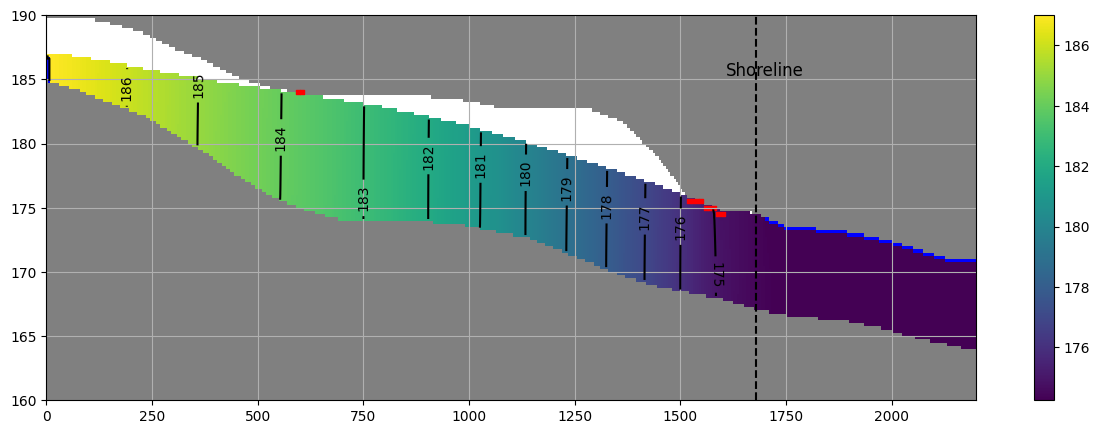

In [447]:
fig = plt.figure(figsize=(15, 5))
xsect = flopy.plot.PlotCrossSection(model=model, line={"Column": 0})

hds = flopy.utils.binaryfile.HeadFile(model_ws + '/example_model.hds')
head_data = hds.get_data(kstpkper=(0, 0)) # (time step, stress period)

ibd = model.bas6.ibound.array
masked_head_data = np.ma.masked_where(ibd== 0, head_data)

cs = xsect.plot_array(masked_head_data, cmap="viridis")
plt.colorbar(cs)

contour_levels = np.arange(164, 188, 1)
contour_set = xsect.contour_array(masked_head_data, levels=contour_levels, colors="black")
plt.clabel(contour_set, inline=True, fontsize=10, fmt="%1.0f")
plt.grid()

ibd = xsect.plot_ibound(color_noflow='grey')
#ibd.set_facecolor("red")  # set the color of the masked cells to grey

plt.axvline(x=1680, color='black', linestyle='--')

plt.text(1700, 185, 'Shoreline', ha='center', va='bottom', fontsize=12)
xs = drn_ys
ys = [ lay_to_meter(locate_ground_surface_lay(meter_to_row(y))) for y in drn_ys]
plt.scatter([x - 0.0 for x in xs],[y- 0.0 for y in ys],c='r',marker='s',s=5)

plt.show()

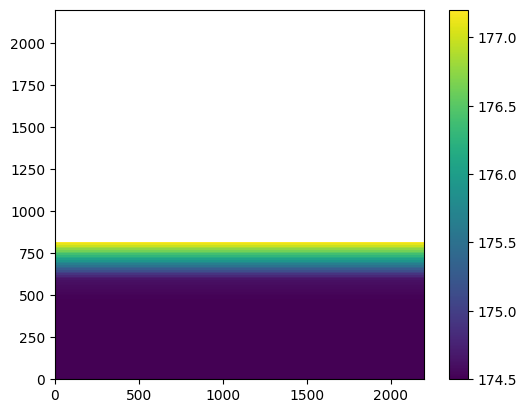

In [248]:

mapview = flopy.plot.PlotMapView(model=model,layer=40)

masked_head_data = np.ma.masked_where(ibd== 0, head_data)

mp = mapview.plot_array(masked_head_data)

plt.colorbar(mp)


In [410]:
from flopy.utils.postprocessing import get_water_table

hds = flopy.utils.binaryfile.HeadFile(model_ws + '/example_model.hds')
head_data = hds.get_data(kstpkper=(0, 2)) # (time step, stress period)
arr= head_data[:,:,0]
arr[np.where(arr<0)] = np.nan
# create a boolean array where True where arr > 0 and False elsewhere
bool_arr = arr > 0

# use argmax along axis 0 to find the index of the first True value for each column
wt = np.argmax(bool_arr, axis=0)
wt

array([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,
        9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15,
       15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21,
       21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24,
       25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28,
       29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       31, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 36, 36, 36, 36, 36, 36, 36,
       36, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38],
      dtype=int64)

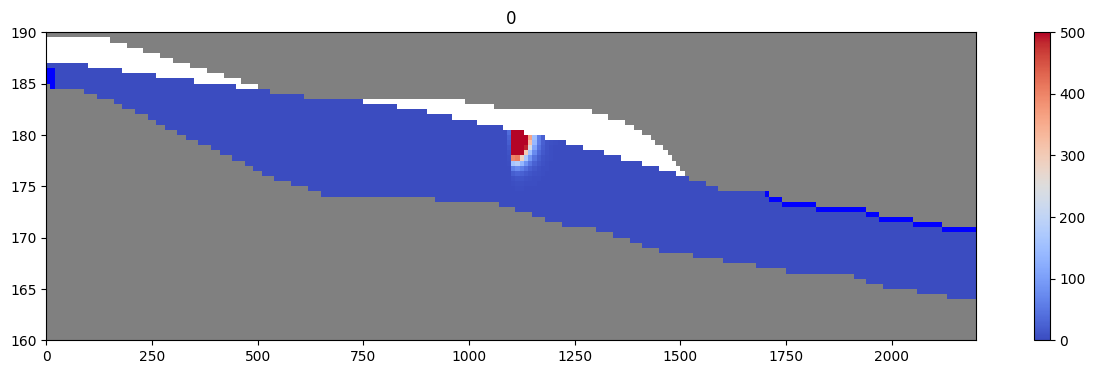

In [411]:

### read data
kper = 0
col = int(ncol)/2

# Read the concentration data from the UCN file
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

# Mask the inactive cells
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)



### plotting# ####################

fig = plt.figure(figsize=(15, 4))

line = {"Column": col}

# Create a PlotCrossSection object for the model
xsect = flopy.plot.PlotCrossSection(model=model, line=line)

# Plot the concentration results
cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0, vmax=500)
plt.colorbar(cs)
ibd = xsect.plot_ibound(color_noflow='grey')
plt.title(kper)
plt.show()

##------------------------



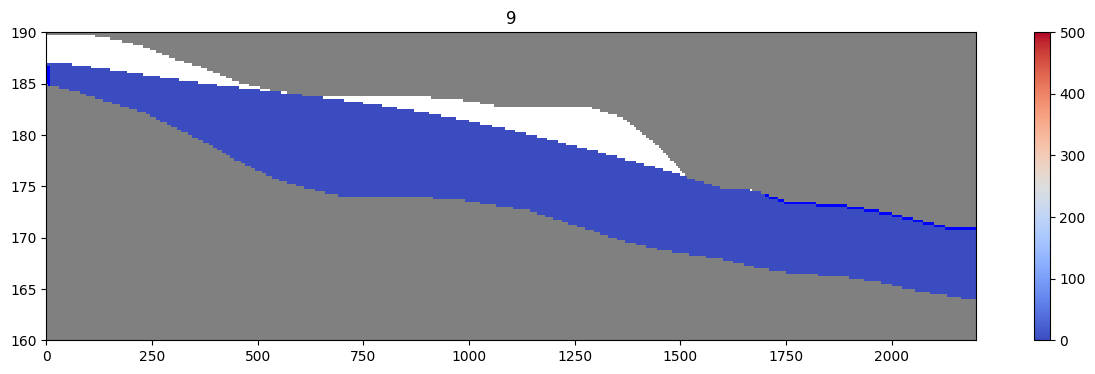

In [463]:

### read data
kper = 9
col = int(ncol)/2

# Read the concentration data from the UCN file
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

# Mask the inactive cells
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)



### plotting# ####################

fig = plt.figure(figsize=(15, 4))

line = {"Column": col}

# Create a PlotCrossSection object for the model
xsect = flopy.plot.PlotCrossSection(model=model, line=line)

# Plot the concentration results
cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0, vmax=500)
plt.colorbar(cs)
ibd = xsect.plot_ibound(color_noflow='grey')
plt.title(kper)
plt.show()
##------------------------



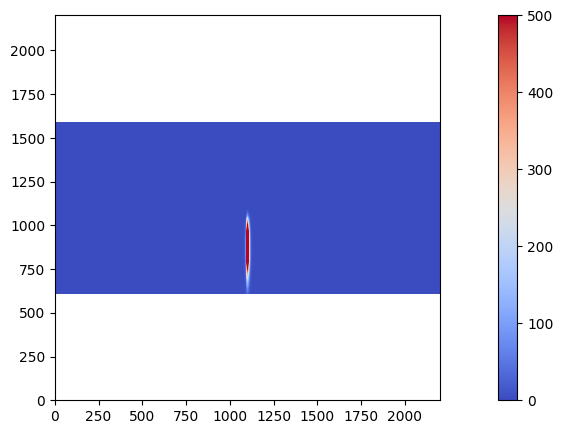

In [455]:
kper = 9
lay = int(30*2)

fig = plt.figure(figsize=(15, 5))
mapview = flopy.plot.PlotMapView(model=model, layer=lay)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

ibound = model.bas6.ibound.array
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

cs = mapview.plot_array(masked_conc_data, cmap='coolwarm', vmin=0, vmax=500)
plt.colorbar(cs)

# Show the plot
plt.show()

In [456]:
### read data
kper = 9
col = int(ncol)/2

# Read the concentration data from the UCN file
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

# Mask the inactive cells
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

In [460]:
arr = concentration_array[int(30*2),:,int(ncol/2)]

In [461]:
arr[np.where(arr==1e30)] = 0
arr[np.where(arr<0.01)] = 0

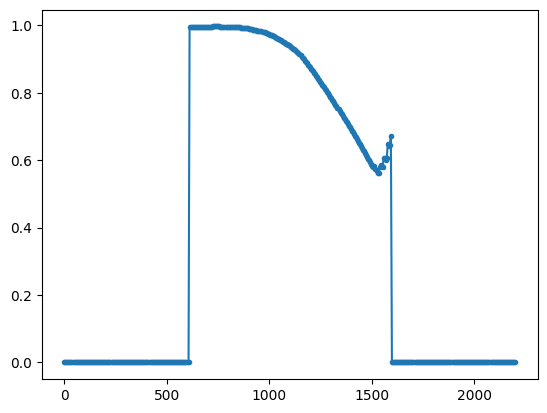

In [462]:
ys = arr
xs = np.linspace(0,2200,len(arr))
plt.plot(xs,ys,marker='.')

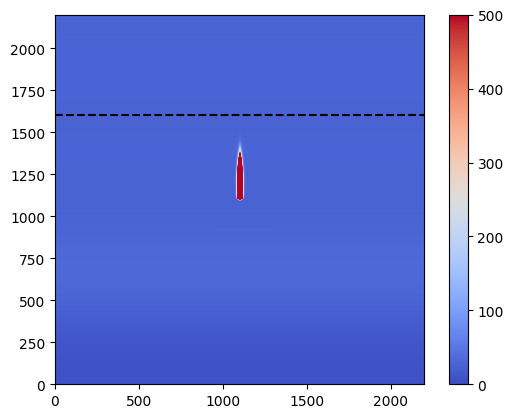

In [303]:
import flopy.utils.binaryfile as bf
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)
#------------------#
kper = 4

mapview = flopy.plot.PlotMapView(model=model)
conc = budobj.get_data(kstpkper=(0, kper))
conc[conc==1.e+30]=0
arr = conc.sum(axis=0)
arr = np.flip(arr,axis=0)

mp = mapview.plot_array(arr, cmap='coolwarm', vmin=0, vmax=500)
plt.axhline(y=1600,c='k',linestyle='dashed')
plt.colorbar(mp)

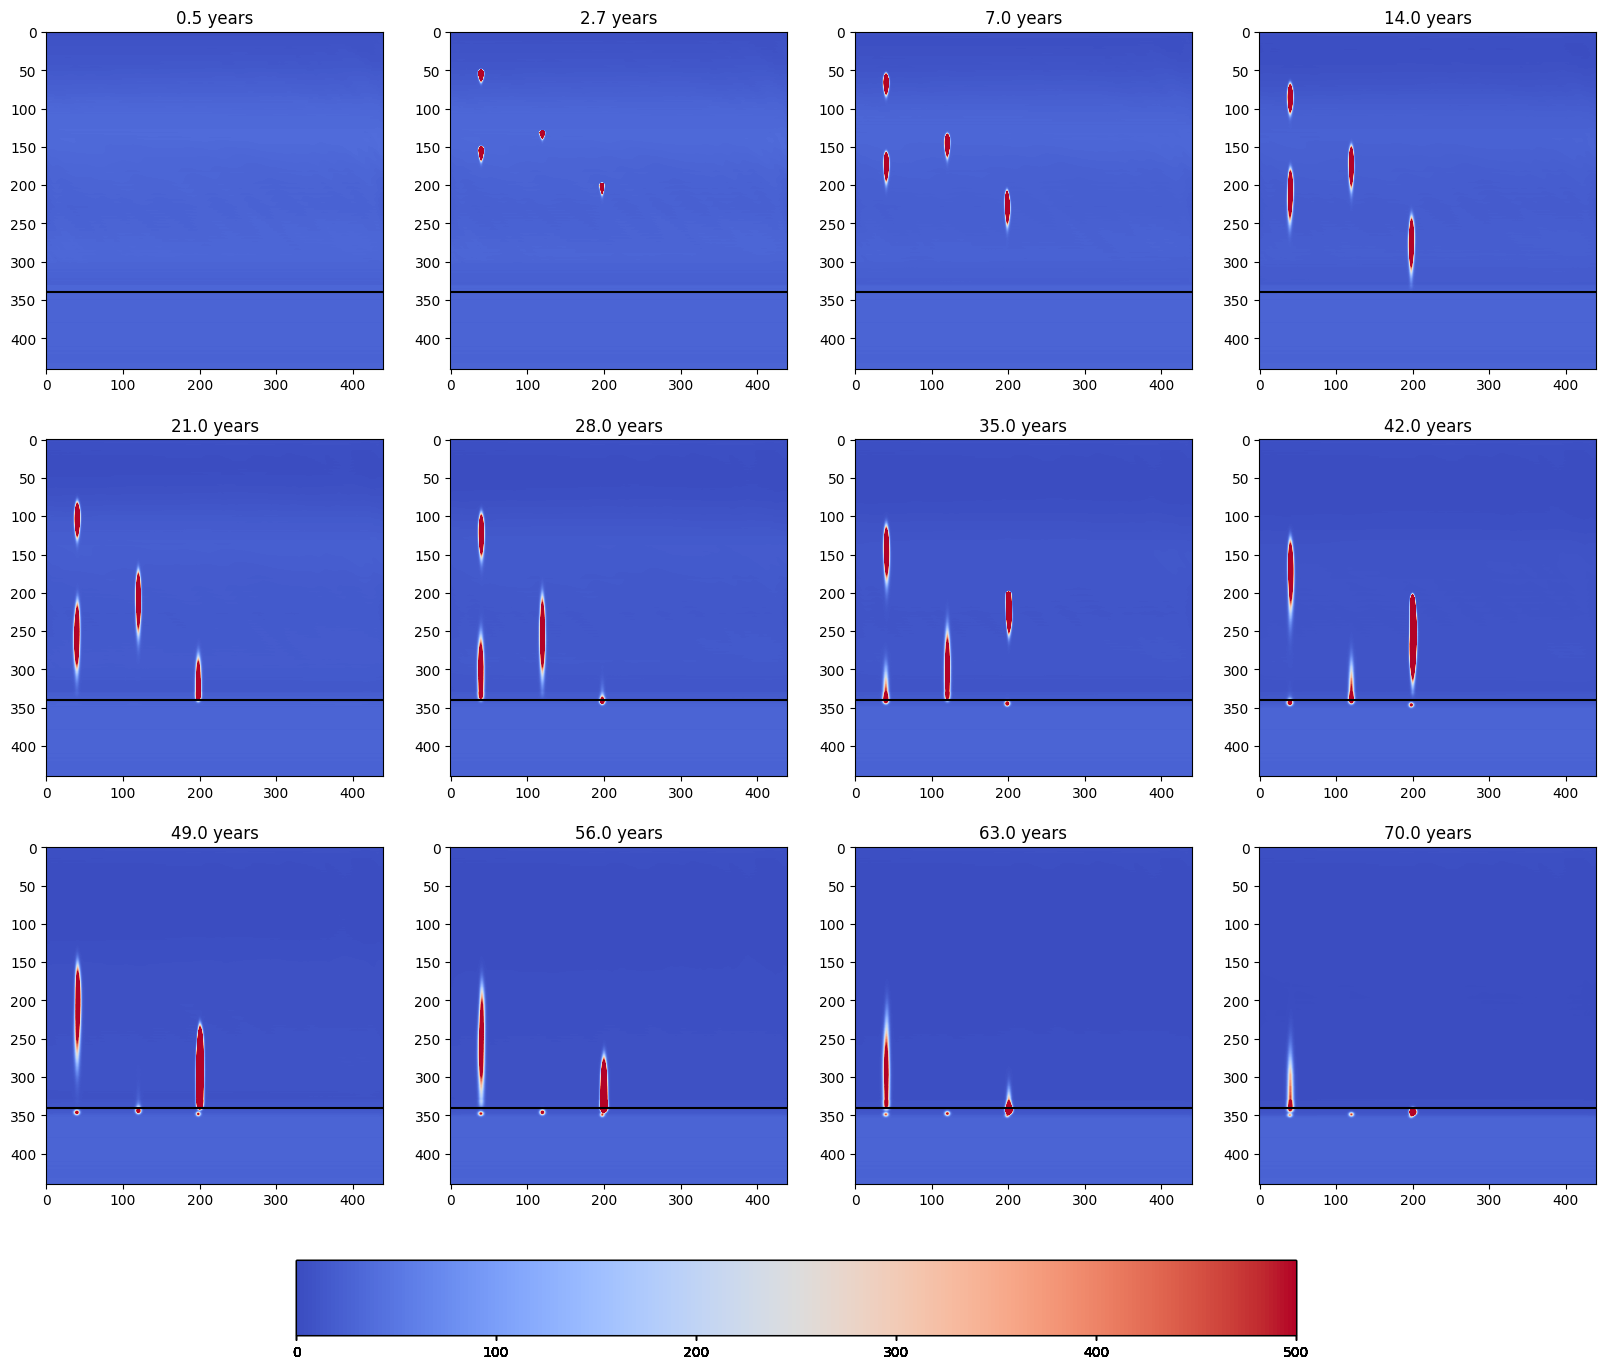

In [511]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(3, 4)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,12)]

# Loop over the selected time indices
for n in range(12):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=170*2, c='k')

# Set the size of the figure
fig.set_size_inches(20, 15)

In [ ]:
# Create a figure with 2 rows and 4 columns of subplots
fig, axes = plt.subplots(2, 4)

# Load the concentration data from the UCN file
budobj = bf.UcnFile(model_ws + '/MT3D001.UCN', model=model)

# Get the times for which concentration data is available
times = budobj.get_times()

# Select 8 time indices evenly spaced throughout the simulation period
selected_indices = [int(n) for n in np.linspace(0, len(times)-1,8)]

# Loop over the selected time indices
for n in range(8):
    # Get the concentration data for the selected time
    conc = budobj.get_data(totim=times[selected_indices[n]])
    conc[conc==1.e+30] = 0
    
    # Flatten the axes array and select the nth subplot
    ax = axes.flatten()[n]
    
    # Plot the sum of the concentration data over the x-axis
    im1 = ax.imshow(np.sum(conc, axis=0), cmap='coolwarm', vmin=0, vmax=500)
    
    # Add a colorbar to the figure
    cbar_ax = fig.add_axes([0.25, 0.01, 0.5, 0.05])
    fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    
    # Set the title of the subplot to the selected time in years
    ax.set_title('{:.1f} years'.format(times[selected_indices[n]]/365))
    
    # Add a shoreline  to the subplot
    ax.axhline(y=140, c='k')

# Set the size of the figure
fig.set_size_inches(20, 8)

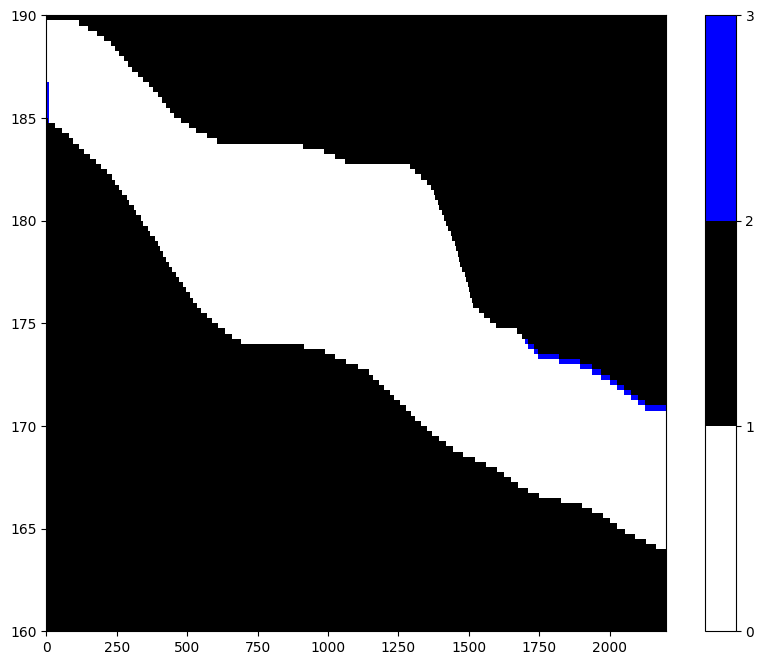

In [ ]:
xsect = flopy.plot.crosssection.PlotCrossSection(model=model, line={'Column': 100})
patches = xsect.plot_ibound()
plt.colorbar(patches)
plt.gcf().set_size_inches(10,8)

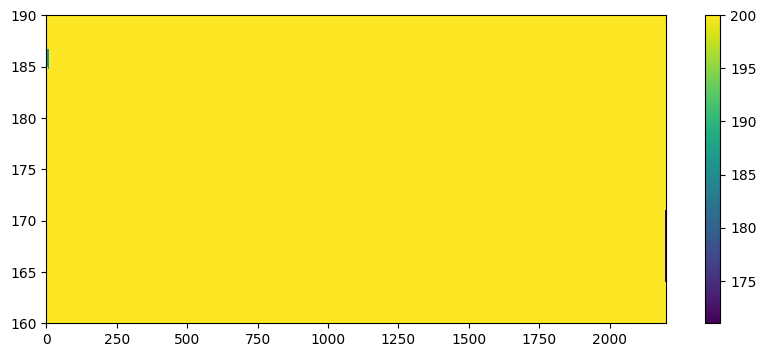

In [ ]:
xsect = flopy.plot.crosssection.PlotCrossSection(model=model, line={'Column': 100})
patches = xsect.plot_array(bas.strt.array)
plt.colorbar(patches)
plt.gcf().set_size_inches(10,4)